## Image Filtering

This notebook provides a quick guide to understanding image filtering with openCV.  
In this context, image filtering just means adding a brightening or darkening shader to the existing image.


In [1]:
# imports
import cv2
import numpy as np
import copy

# for timing
import time



We will work with the following images I have on my phone, one from Toronto, one from New York City.  
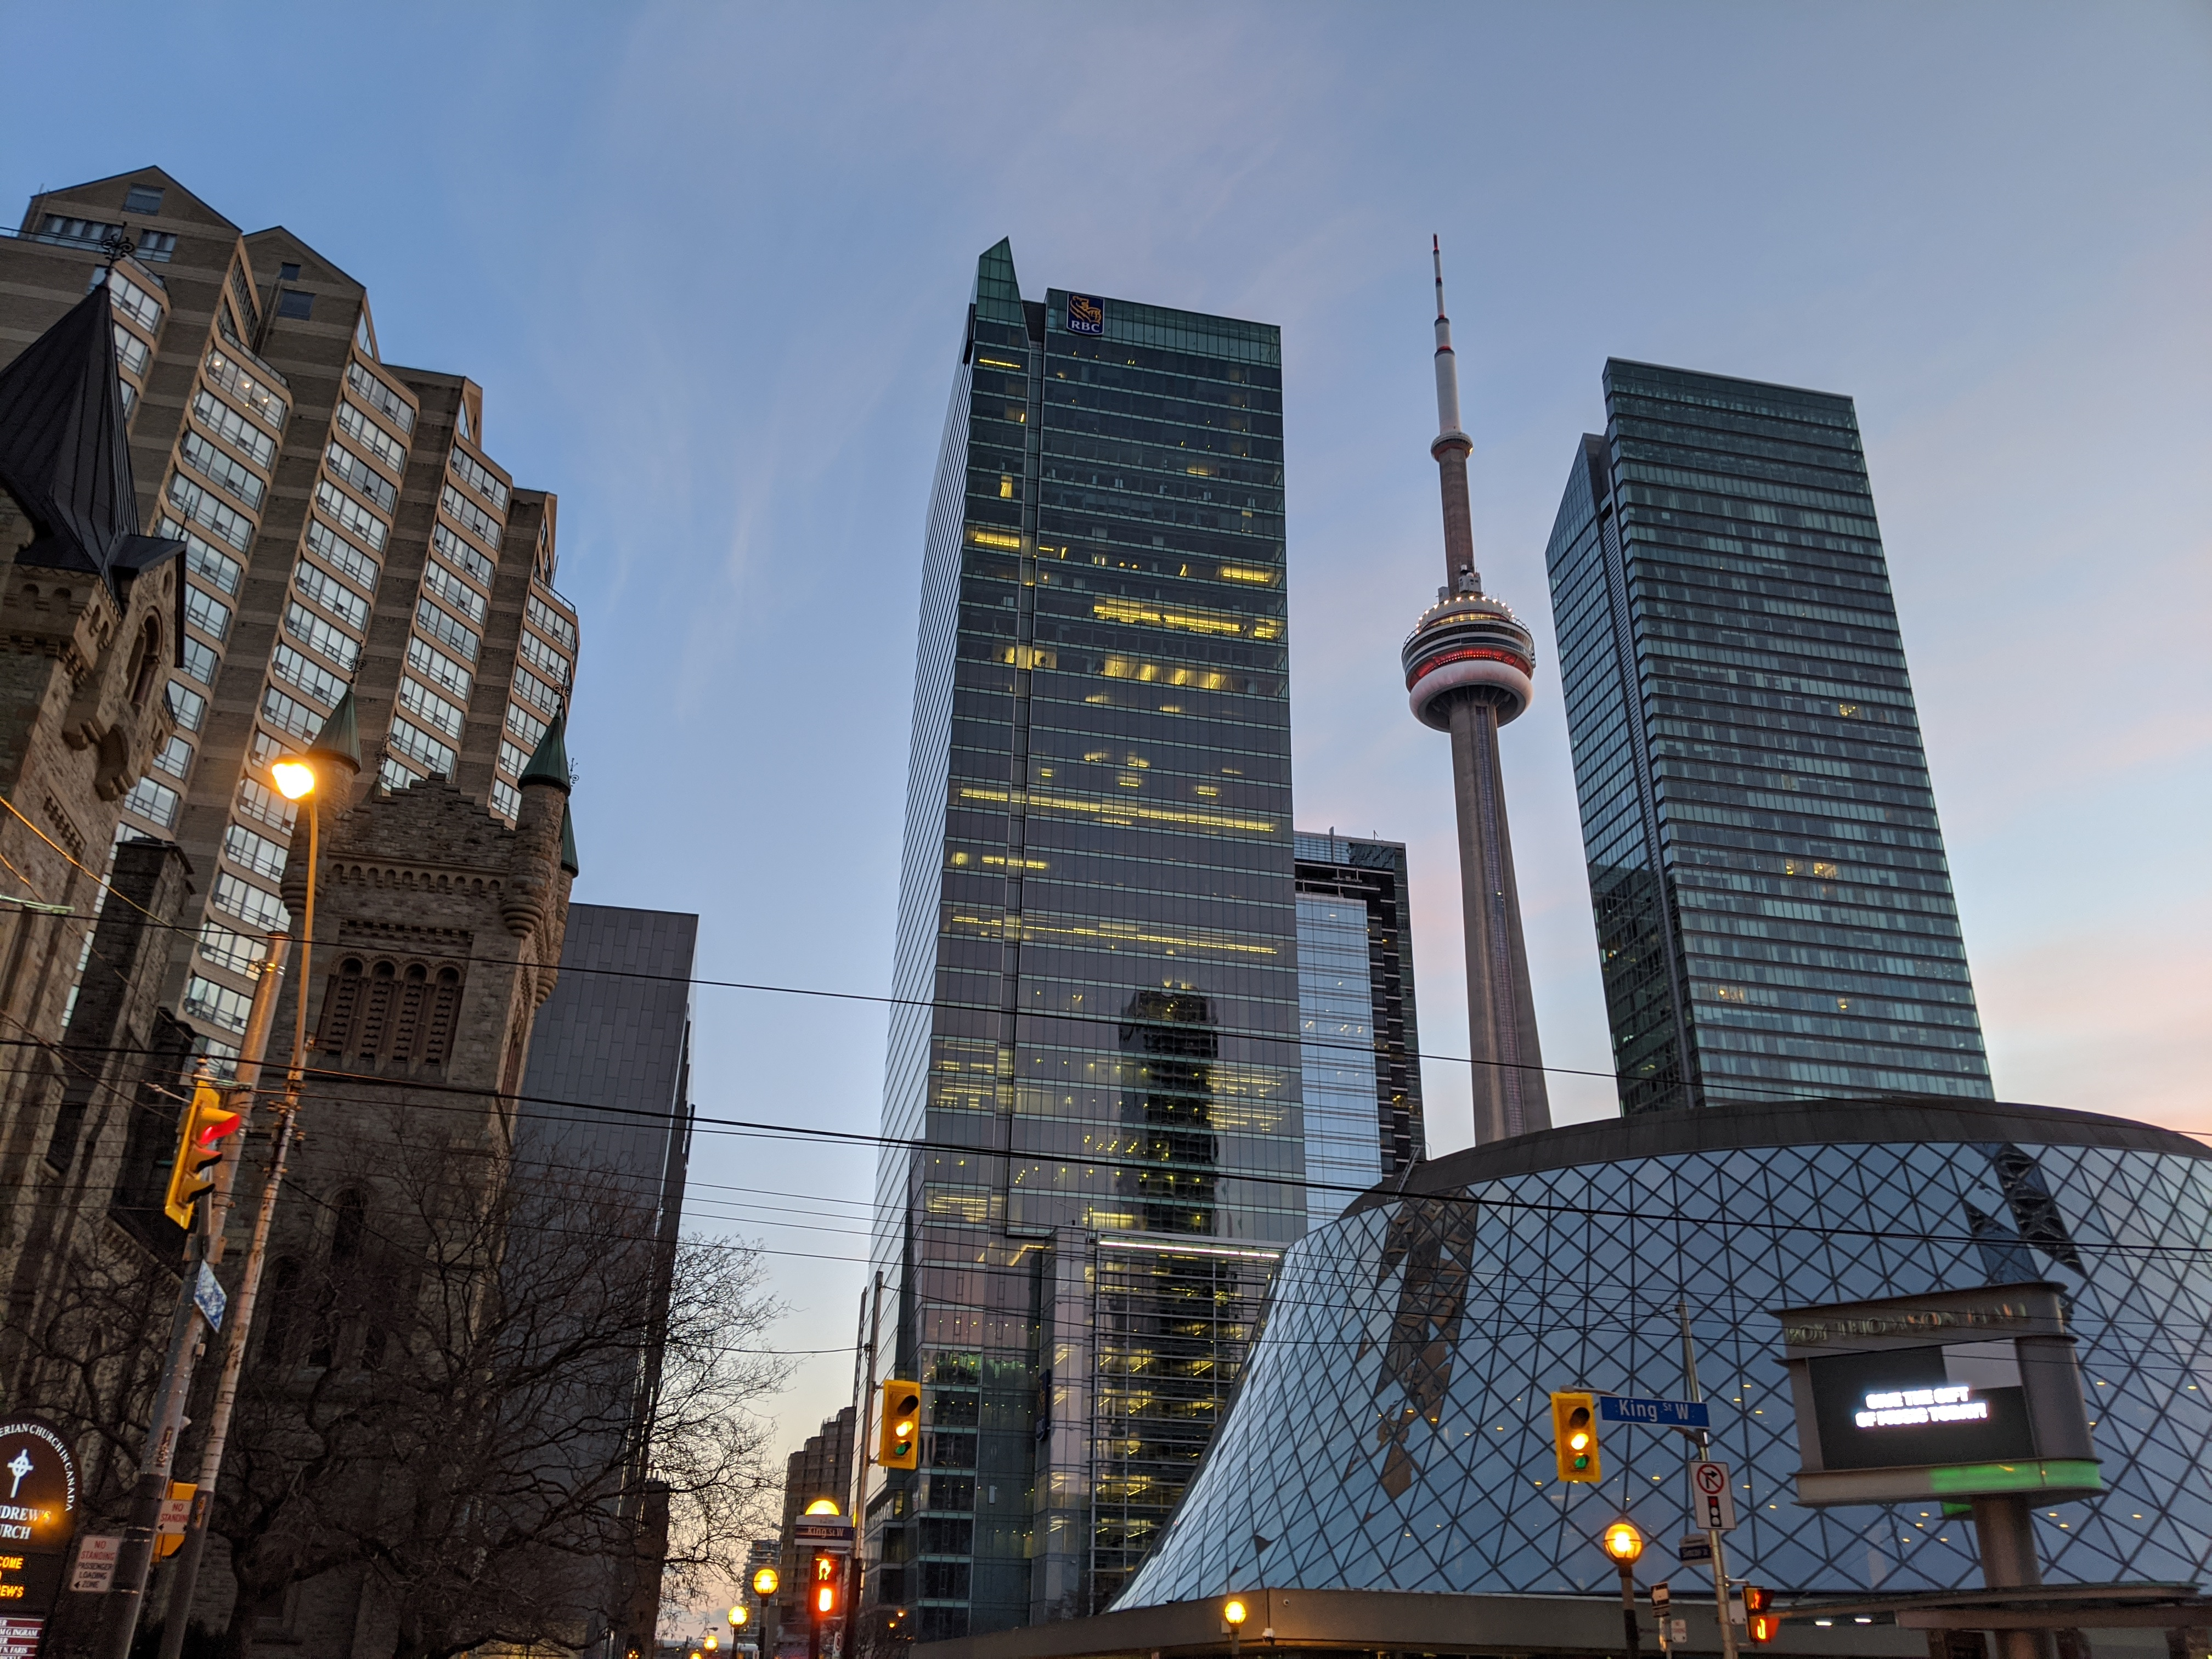  
*Toronto*  

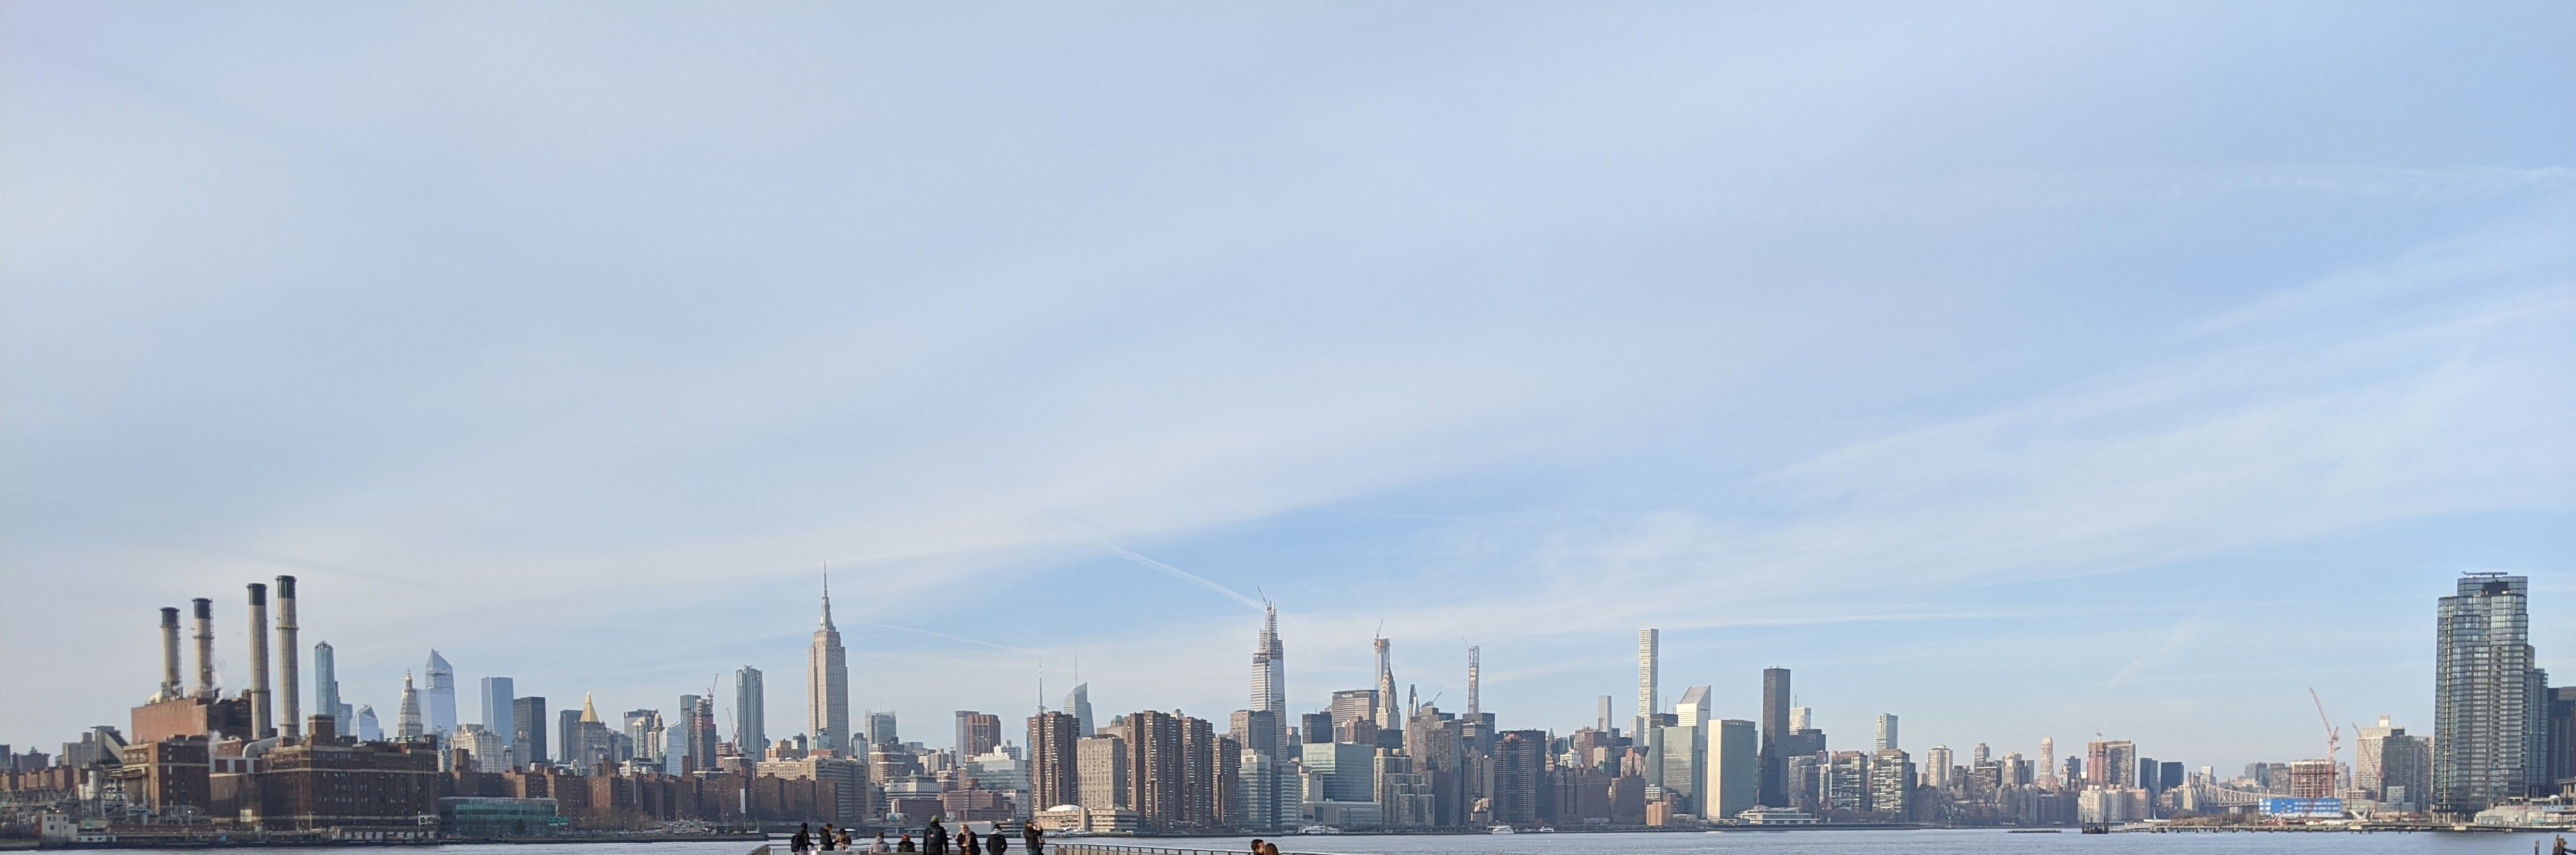
*NYC*  


Note that the function below (display) will be used to open the image on our computer, rather than saving multiple copies and expanding this notebook to a ridiculous length.  



In [2]:
# display function - display image temporariliy on our computer
def display(img):
    cv2.imshow('image',img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

The first thing we want to do is load the images. OpenCV allows us to load the images as Numpy arrays.

In [50]:
imgpath = './/imgs'
imgs = {'Toronto':cv2.imread(r'{}\toronto.jpg'.format(imgpath)), 'NYC':cv2.imread(r'{}\nyc.jpg'.format(imgpath))}
print('Shape of Toronto Image:', imgs['Toronto'].shape)
print('Shape of NYC Image:', imgs['NYC'].shape)

Shape of Toronto Image: (3024, 4032, 3)
Shape of NYC Image: (1339, 4032, 3)


For our purposes, these images might be a bit too large. I am going to resize them to a bit more of a manageable size. We will reduce them to a quarter their current size.

In [51]:
# note that for some reason, we have to reverse the width/height arguments with cv2.resize
for k, _img in imgs.items():
    new_size = (int((_img.shape[1] * 0.25)),int((_img.shape[0] * 0.25)))
    print(new_size)
    imgs[k] = cv2.resize(_img, new_size)
    # let's just make sure our images are saved in the correct integer format
    imgs[k].astype(np.uint8)
    
print('New shape of Toronto Image:', imgs['Toronto'].shape)
print('New shape of NYC Image:', imgs['NYC'].shape)
display(imgs['Toronto'])
display(imgs['NYC'])

(1008, 756)
(1008, 334)
New shape of Toronto Image: (756, 1008, 3)
New shape of NYC Image: (334, 1008, 3)


#### Shape
If we look at the shape of the images printed above, we can identify the general dimensions. Height is the first element, then width, but we are then given a third dimension of 3.  
This final dimension is for RGB colour channels. If we wanted a greyscale image, that third dimension would be reduced to just one value (i.e. Toronto shape would be (756, 1008, 3)).  

#### Filtering
If we want to brighten or darken an image, the process is quite simple. All we have to do is increase or decrease the pixel values (the final array dimension). A uniform change across the array will evenly brighten/darken the image. We can also apply the effect on a gradient.  

What's a good way to apply an effect across the entire array? We can try a basic loop and check its performance.

In [5]:
# we can try looping across the array, and applying a uniform brightening of 50%
test_img = copy.deepcopy(imgs['NYC'])

start = time.time()

for i in range(len(test_img)):
    for j in range(len(test_img[i])):
        for k in range(len(test_img[i][j])):
            # we set the minimum of 255 or the new value, as 255 is the max value in the RGB channel.
            # we add a 50% increase over the current pixel value
            value = test_img[i][j][k] * 0.5
            test_img[i][j][k] = min(255, test_img[i][j][k]+value)


print('Total time taken:', time.time() - start)
display(test_img)

Total time taken: 7.277053117752075


That loop took around 7 seconds, which isn't neccessarily slow, but if we had to brighten many images, then we might have a terribly slow process.  
Remember that we have the image saved as an array. If we consider matrix operations with numpy, we could probably save a ridiculous amount of time on the same process.  

When operating on an array in that manner, we will need to take advantage of one of Python's built-in functionalities - lambdas.  
These are user-defined, one-line functions that can be applied over an iterating object, such as during a matrix operation.

In [15]:
# this is our brightening lambda - x represents any value being added. We submit pct as a global variable
pct = 50
brighten = lambda x: min(255, x + (x * (pct/100)))

# numpy offers the option to vectorize a function, such as our lambda. This will allow us to apply
# the functionality over an entire array, much quicker than our own loop would.
start = time.time()
array_brighten = np.vectorize(brighten)
test_img = array_brighten(imgs['NYC'])
test_img = test_img.astype(np.uint8)
print('Total time taken:', time.time() - start)
display(test_img)

Total time taken: 0.43940186500549316


Much quicker!  

Now that we have a good foundation for applying solid filtering, we can consider how a gradident filter would be applied. A gradient is essentially a brightening/darkening of an image, from a lower percentage to a higher percentage across the entire image.  
If we think about it in terms of our image matrix, rows at the start would have a lower percentage change, which would increase row by row until we reach the other end of the image.  

Knowing that it is much quicker to apply matrix operations, rather than looping over the image, what funcitonality can we take advantage of to make this happen?  

Numpy has many options that can help us here. But first, let's conceptualize how we can quickly apply a gradient across an image.  

Let's consider a brightening gradient, which gets progressively brighter from left to right. Let's pretend we have a 5x5 image. The percentage change will be 20%-100%.  
These are the perctange changes to apply:  
[[20,40,60,80,100]  
[20,40,60,80,100]  
[20,40,60,80,100]  
[20,40,60,80,100]  
[20,40,60,80,100]]


One of the easiest ways to apply this would be to create the above matrix, and then create a new matrix with a *Hadamard Product*, between this and the original image. The followimg image comes from Wikipedia, describing the operation - https://en.wikipedia.org/wiki/Hadamard_product_(matrices).  
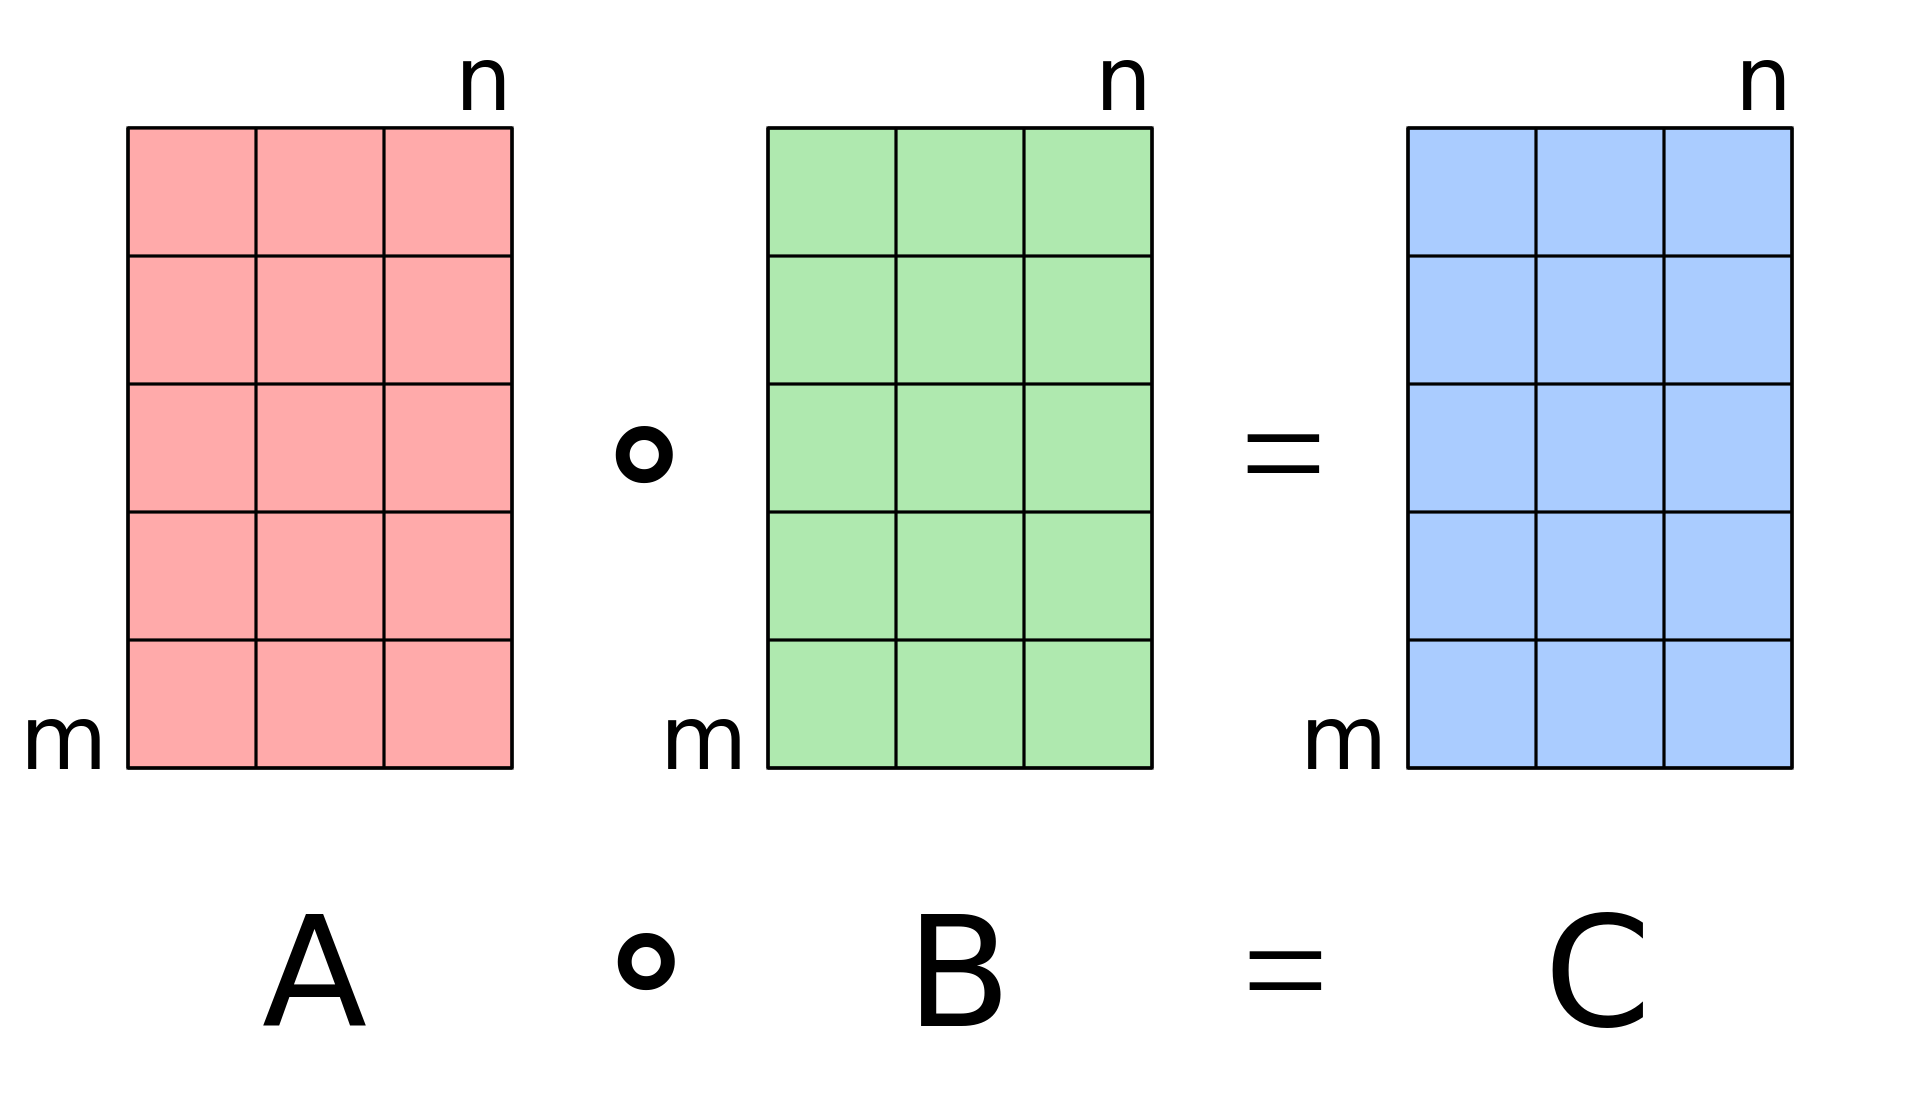  

So we know how we can generate the updated image matrix. Now, we just need to figure out how to generate the percent change matrix. The functionalities from numpy we can use include MGrid, Tile, and Stack.  
https://docs.scipy.org/doc/numpy/reference/generated/numpy.mgrid.html  
https://docs.scipy.org/doc/numpy/reference/generated/numpy.tile.html?highlight=tile#numpy.tile  
https://docs.scipy.org/doc/numpy/reference/generated/numpy.stack.html?highlight=stack#numpy.stack  

MGrid - "nd_grid instance which returns a dense multi-dimensional “meshgrid”."  
Tile = "Construct an array by repeating A the number of times given by reps."  
Stack - "Join a sequence of arrays along a new axis."   

For a vertical gradient, i.e. starting from the leftmost column, and progressing to the rightmost with increasing brightness, we will use some of these functions to create the percentage matrix.

In [32]:
# define a basic 5x1 mgrid --> we set 101 as this operation is exclusive on the top value
new_grid = np.mgrid[20:101:20]
print('Initial Grid')
print(new_grid)
print(new_grid.shape)
print('\n')
# to create vertical columns of the same numbers, we can stack the above grid
grid_list = []
for i in range(5):
    grid_list.append(new_grid)
grid_tu = tuple(grid_list) # tuple is required submission for np.stack
stack_grid = np.stack(grid_tu)
print('Grid Stacking')
print(stack_grid)
print(stack_grid.shape)
print('\n')
# if we wanted this running in a different direction, can just transpose
stack_grid_T = stack_grid.T
print(stack_grid_T)
print('\n')
# the last thing to do is make the stack_grid shape broadcastable against our image
# note that right now it is only 2-dimensional
stack_grid = stack_grid_T.reshape((5,5,1))
print('stack grid new shape: ', stack_grid.shape)
print(stack_grid)

Initial Grid
[ 20  40  60  80 100]
(5,)


Grid Stacking
[[ 20  40  60  80 100]
 [ 20  40  60  80 100]
 [ 20  40  60  80 100]
 [ 20  40  60  80 100]
 [ 20  40  60  80 100]]
(5, 5)


[[ 20  20  20  20  20]
 [ 40  40  40  40  40]
 [ 60  60  60  60  60]
 [ 80  80  80  80  80]
 [100 100 100 100 100]]


stack grid new shape:  (5, 5, 1)
[[[ 20]
  [ 20]
  [ 20]
  [ 20]
  [ 20]]

 [[ 40]
  [ 40]
  [ 40]
  [ 40]
  [ 40]]

 [[ 60]
  [ 60]
  [ 60]
  [ 60]
  [ 60]]

 [[ 80]
  [ 80]
  [ 80]
  [ 80]
  [ 80]]

 [[100]
  [100]
  [100]
  [100]
  [100]]]


In [34]:
# the last thing we need before applying the hadamard product to 2 matrices is a lambda function
# x input comes from the image. y input comes from the percentage matrix
brighten_gradient = lambda x, y: min(255, x + (x * (y/100)))
array_brighten = np.vectorize(brighten_gradient)

# define a new "image" array
test_img = np.ones((5,5,3))
print(test_img.shape)

start = time.time()

test_img = array_brighten(test_img, stack_grid)
print('Total time taken:', time.time() - start)
print('Gradient applied to image')
print(test_img)

(5, 5, 3)
Total time taken: 0.0009968280792236328
Gradient applied to image
[[[1.2 1.2 1.2]
  [1.2 1.2 1.2]
  [1.2 1.2 1.2]
  [1.2 1.2 1.2]
  [1.2 1.2 1.2]]

 [[1.4 1.4 1.4]
  [1.4 1.4 1.4]
  [1.4 1.4 1.4]
  [1.4 1.4 1.4]
  [1.4 1.4 1.4]]

 [[1.6 1.6 1.6]
  [1.6 1.6 1.6]
  [1.6 1.6 1.6]
  [1.6 1.6 1.6]
  [1.6 1.6 1.6]]

 [[1.8 1.8 1.8]
  [1.8 1.8 1.8]
  [1.8 1.8 1.8]
  [1.8 1.8 1.8]
  [1.8 1.8 1.8]]

 [[2.  2.  2. ]
  [2.  2.  2. ]
  [2.  2.  2. ]
  [2.  2.  2. ]
  [2.  2.  2. ]]]


In [94]:
# knowing that this workds properly, let's test this on our toronto image
# we want the gradient to go left-right, increasing in brightness
bright_low = 20
bright_high = 120
# the increment size also defines how many columns get added. we want the number to add up to the actual width
increment = (bright_high - bright_low) / imgs['Toronto'].shape[1] # divide by the width of the image
print(increment)
print(imgs['Toronto'].shape[1])

0.0992063492063492
1008


In [95]:
# define the grid
grad_grid = np.mgrid[bright_low:bright_high:increment]
print(grad_grid)
assert len(grad_grid) == imgs['Toronto'].shape[1]

[ 20.          20.09920635  20.1984127  ... 119.70238095 119.8015873
 119.90079365]


In [96]:
# append the grid n times, where n is the images height
grad_stack = []
for i in range(imgs['Toronto'].shape[0]):
    grad_stack.append(grad_grid)
grad_stack = tuple(grad_stack)
# stack and transpose
gr = np.stack(grad_stack)
grT = gr.T

# reshape
grad_matrix = grT.reshape((imgs['Toronto'].shape[0],imgs['Toronto'].shape[1],1))
#grad_matrix = grT.reshape((imgs['Toronto'].shape[0],imgs['Toronto'].shape[1],1))

In [97]:
grad_matrix = grad_matrix.astype(np.uint8)
print(imgs['Toronto'].shape, grad_matrix.shape)

(756, 1008, 3) (756, 1008, 1)


In [106]:
# now we can apply the lambda from above

start = time.time()
_img = imgs['Toronto'].astype(np.uint8)
test_img = array_brighten(_img, grad_matrix)
test_img = test_img.astype(np.uint8)

print('Total time taken:', time.time() - start)
print('Gradient applied to image')
display(test_img)

Total time taken: 1.0046393871307373
Gradient applied to image


Around 1 second. Not bad, especially for the size of the image.  
We should also check how darkening an image would work. 
Once again, we need to consider our colour values. Since they fit between [0, 255], we will be lowering them towrds 0 to darken. However, we cannot go below 0, or it will cause an error. We can use max(), the opposite of min(), to select the higher value between 0 and the darkened value.  

Let's also try this horizontally, i.e. the shading goes top to bottom.

In [133]:
# we will use the NYC iamge this time
darken_gradient = lambda x, y: max(0, x + (x * (y/100)*-1)) #-1 so that the addition is actually a subtraction
array_darken = np.vectorize(darken_gradient)

dark_low = 30
dark_high = 90

# the increment size also defines how many columns get added. we want the number to add up to the actual width
increment = (dark_high - dark_low) / imgs['NYC'].shape[0] # divide by the width of the image
grad_grid = np.mgrid[dark_low:dark_high:increment]
assert len(grad_grid) == imgs['NYC'].shape[0]

In [126]:
# we use np.tile on the grid to create the proper matrix
grad_tile = np.tile(grad_grid,(imgs['NYC'].shape[1],1)).T
print(imgs['NYC'].shape, grad_tile.shape)

(334, 1008, 3) (334, 1008)


In [127]:
grad_matrix = grad_tile.reshape((imgs['NYC'].shape[0],imgs['NYC'].shape[1],1))
print(grad_matrix.shape)

(334, 1008, 1)


In [134]:
start = time.time()

_img = imgs['NYC'].astype(np.uint8)
test_img = array_darken(_img, grad_matrix)
test_img = test_img.astype(np.uint8)

print('Total time taken:', time.time() - start)
print('Gradient applied to image')
display(test_img)

Total time taken: 0.5199501514434814
Gradient applied to image


In [144]:
# lastly, let's save a few versions of these photos
# brightened toronto, darkened New York

# TORONTO IMAGE
bright_low = 0
bright_high = 300
increment = (bright_high - bright_low) / imgs['Toronto'].shape[1]
grad_grid = np.mgrid[bright_low:bright_high:increment]
grad_stack = []
for i in range(imgs['Toronto'].shape[0]):
    grad_stack.append(grad_grid)
grad_stack = tuple(grad_stack)
gr = np.stack(grad_stack)
grT = gr.T
grad_matrix = grT.reshape((imgs['Toronto'].shape[0],imgs['Toronto'].shape[1],1))
toronto_img = imgs['Toronto'].astype(np.uint8)
toronto_img = array_brighten(toronto_img, grad_matrix)
toronto_img = toronto_img.astype(np.uint8)

# NYC IMAGE - reversing the values reverses the gradient (bottom to top)
dark_low = 99
dark_high = 45
increment = (dark_high - dark_low) / imgs['NYC'].shape[0]
grad_grid = np.mgrid[dark_low:dark_high:increment]
grad_tile = np.tile(grad_grid,(imgs['NYC'].shape[1],1)).T
grad_matrix = grad_tile.reshape((imgs['NYC'].shape[0],imgs['NYC'].shape[1],1))
nyc_img = imgs['NYC'].astype(np.uint8)
nyc_img = array_darken(nyc_img, grad_matrix)
nyc_img = nyc_img.astype(np.uint8)

In [145]:
cv2.imwrite("{}\\toronto_brightened.jpg".format(imgpath), toronto_img)
cv2.imwrite("{}\\nyc_darkened.jpg".format(imgpath), nyc_img)

True

Let's have a look at our final outputs!
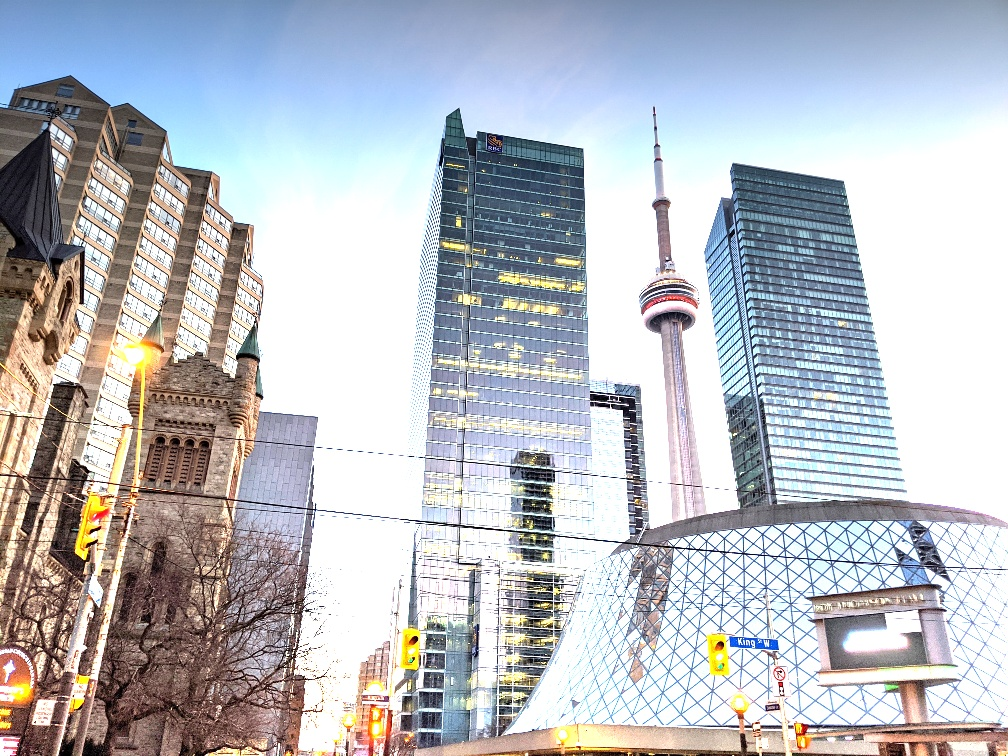
*Toronto, but make it brighter*

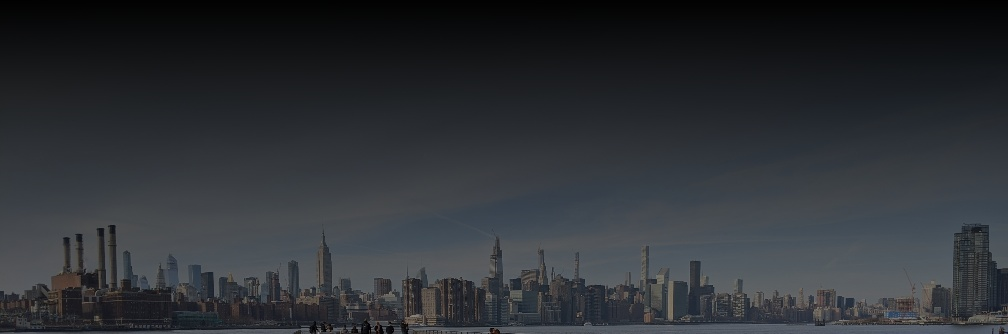
*New York, but make it really hazy.*